In [1]:
!pip install pennylane
!pip install pennylane pennylane-lightning[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 135.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.3/913.3 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 10.0 MB/s eta 0:00:00


### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.templates import QFT
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml, load_digits
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from pennylane import numpy as pnp
from skimage.transform import resize
from keras.datasets import mnist

### Step 1:  Dataset Preparation

* Load MIST dataset - 0/1 pixel intensities
* Reduce image to 8x8
    * Resizing using skimage
    * Crop and pad (zero-padding)
* Normalize all images:
  8x8 image -> flatten -> vector of length 64 -> normalize
* Train/Test split

In [3]:
# loading mnist from openML
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist['data'].astype(np.uint8)
y = mnist['target'].astype(np.uint8)
y = y.to_numpy()

In [4]:
# focus on binary classification
mask = (y == 0) | (y == 1)
X, y = X[mask], y[mask]
X.shape

(14780, 784)

In [5]:
n_samples = 100 # restricting to 6000 samples for now

perm = np.random.permutation(len(X))
X = X.to_numpy()
X, y = X[perm], y[perm]

X = X[:n_samples]
y = y[:n_samples]

Binarising (makes amplitude preparation stable and simplifies qjpeg vectorization)

In [6]:
X_bin = (X > 127).astype(np.uint8)
X_bin = np.array(X_bin)
X_bin.shape

(100, 784)

Reducing images to 8x8 + flattening to (, 64)

In [7]:
# convert each 28x28 binarised image to 8x8, then flatten to length 64
def to_8x8_vector(img_row):
    img_2d = np.array(img_row).reshape(28, 28).astype(float)        # reshape flat 784 -> 28x28
    img_8x8 = resize(
        img_2d,
        (8, 8),
        anti_aliasing=False,
        preserve_range=True
    )
    return img_8x8.flatten()   # shape (64,)

# apply to all images
X_8x8 = np.array([to_8x8_vector(x) for x in X_bin], dtype=float)
X_8x8.shape

(100, 64)

L2-normalization of the vectors:

In [8]:
def safe_l2_normalize_rows(X):
    X = X.astype(float)
    Xn = np.zeros_like(X, dtype=float)

    norms = np.linalg.norm(X, axis=1)
    for i, norm in enumerate(norms):
        if norm == 0:
            Xn[i, 0] = 1.0  # fallback to |0...0> amplitude state
        else:
            Xn[i] = X[i] / norm
    return Xn

X_8x8_norm = safe_l2_normalize_rows(X_8x8)
print("Any NaNs?", np.isnan(X_8x8_norm).any())
print("Norm check:", np.min(np.linalg.norm(X_8x8_norm, axis=1)),
      np.max(np.linalg.norm(X_8x8_norm, axis=1)))

Any NaNs? False
Norm check: 0.9999999999999999 1.0


In [9]:
X_8x8_norm.shape

(100, 64)

I'm gonna do the splitting here, and carry both representations consistently

In [10]:
idx = np.arange(n_samples)

idx_train, idx_test, y_train, y_test = train_test_split(
    idx, y, test_size=0.2, random_state=42, stratify=y
)

# QEK inputs (8x8 -> 64 -> normed)
X_train_qek = X_8x8_norm[idx_train]
X_test_qek  = X_8x8_norm[idx_test]

# QJPEG inputs (28x28 binary images)
X_train_img = X_bin[idx_train]
X_test_img  = X_bin[idx_test]

print("QEK train/test:", X_train_qek.shape, X_test_qek.shape)
print("IMG train/test:", X_train_img.shape, X_test_img.shape)
print("Labels train/test:", y_train.shape, y_test.shape)

QEK train/test: (80, 64) (20, 64)
IMG train/test: (80, 784) (20, 784)
Labels train/test: (80,) (20,)


Data preparation is done.

### Step 2: Quantum Embedding & Kernel Training

In [11]:
n_qubits = 6
wires = list(range(n_qubits))

dev = qml.device("lightning.gpu", wires=wires, shots=None)

Defining QEK circuit

In [12]:
def qek_circuit(x, theta):
    """
    Quantum Embedding Kernel circuit U(x; theta)
    """
    layers = theta.shape[0]

    # Encode classical data
    qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=False)

    # Parameterized layers with entanglement
    for l in range(layers):
        for i in range(n_qubits):
            # RX, RY, RZ rotations per qubit
            qml.RX(theta[l, i, 0], wires=i)
            qml.RY(theta[l, i, 1], wires=i)
            qml.RZ(theta[l, i, 2], wires=i)

        # Entanglement (linear chain example)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
        # wrap-around entanglement
        qml.CNOT(wires=[n_qubits-1, 0])

    return qml.state()  # return full quantum state for kernel computation

# Wrap as QNode
qnode = qml.QNode(qek_circuit, dev)

Now we should generate quantum states - we embed training data only here.

In [13]:
layers = 2
# trainable parameters theta initialised here
theta = np.random.uniform(0, 2*np.pi, size=(layers, n_qubits, 3))

# generating quantum states for all images
states_train = np.array([qnode(x, theta) for x in X_train_qek])
states_train.shape

(80, 64)

`states_train` is the quantum feature map. Now we compute kernel matrix

In [14]:
def compute_kernel_matrix(states):
    num_train = states.shape[0]
    K_train = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(num_train):
            inner_prod = np.vdot(states[i], states[j])
            K_train[i,j] = np.real(inner_prod * np.conj(inner_prod))
    return K_train

# Regularize tiny/zero entries
epsilon = 1e-6
K_train = compute_kernel_matrix(states_train)
K_train_norm = K_train / K_train.max()

# sanity check
print("Kernel matrix:")
print(K_train)
print("Diagonal:", np.mean(np.diag(K_train))) # must be around 1
print("Min:", K_train.min(), "Max:", K_train.max())

Kernel matrix:
[[1.         0.18853925 0.06351907 ... 0.0643567  0.35254512 0.16550112]
 [0.18853925 1.         0.08716494 ... 0.08980228 0.32948822 0.64700957]
 [0.06351907 0.08716494 1.         ... 0.99011787 0.04490115 0.10124596]
 ...
 [0.0643567  0.08980228 0.99011787 ... 1.         0.04114246 0.10522275]
 [0.35254512 0.32948822 0.04490115 ... 0.04114246 1.         0.25077706]
 [0.16550112 0.64700957 0.10124596 ... 0.10522275 0.25077706 1.        ]]
Diagonal: 1.0000000000000004
Min: 0.0 Max: 1.0000000000000013


In [15]:
svc = SVC(kernel='precomputed', C=0.01)
svc.fit(K_train_norm, y_train)

SVC(C=0.01, kernel='precomputed')

In [16]:
print("Support vectors per class:", svc.n_support_)
print("Total support vectors:", svc.support_.shape)

Support vectors per class: [37 37]
Total support vectors: (74,)


In [17]:
def test_layers(X_train, X_test, y_train, y_test, layers_list):
    results = {}
    for layers in layers_list:
        theta = np.random.uniform(0, 2*np.pi, size=(layers, n_qubits, 3))
        states_train = np.array([qnode(x, theta) for x in X_train])
        K_train = compute_kernel_matrix(states_train)
        K_train_norm = K_train / K_train.max()
        svc = SVC(kernel='precomputed', C=1.0)
        svc.fit(K_train_norm, y_train)
        states_test = np.array([qnode(x, theta) for x in X_test])
        K_test = np.array([[np.abs(np.vdot(tr, ts))**2 for tr in states_train] for ts in states_test])
        K_test_norm = K_test / K_train.max()
        y_pred = svc.predict(K_test_norm)
        acc = accuracy_score(y_test, y_pred)
        results[layers] = acc
        print(f"Layers {layers}: accuracy = {acc:.4f}")
    return results

layer_results = test_layers(X_train_qek, X_test_qek, y_train, y_test, [2,4,6,8,10,12])

Layers 2: accuracy = 1.0000
Layers 4: accuracy = 1.0000
Layers 6: accuracy = 1.0000
Layers 8: accuracy = 1.0000
Layers 10: accuracy = 1.0000
Layers 12: accuracy = 1.0000


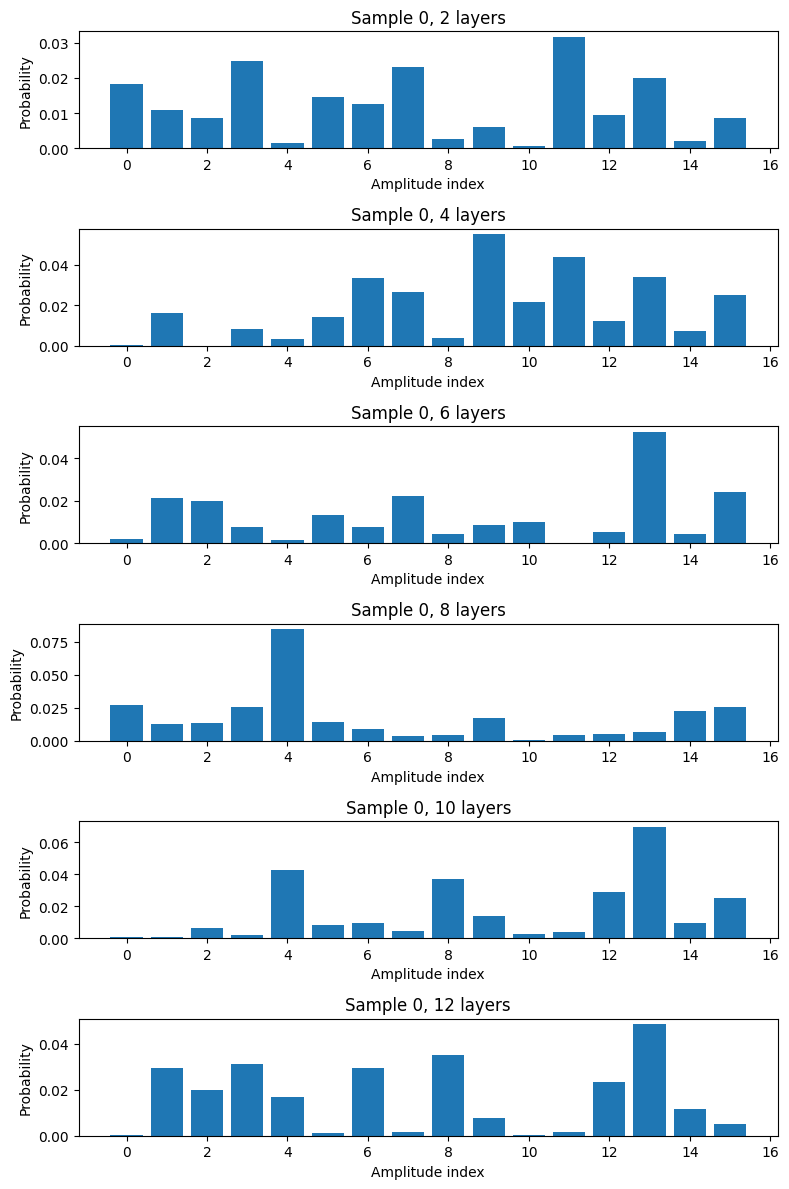

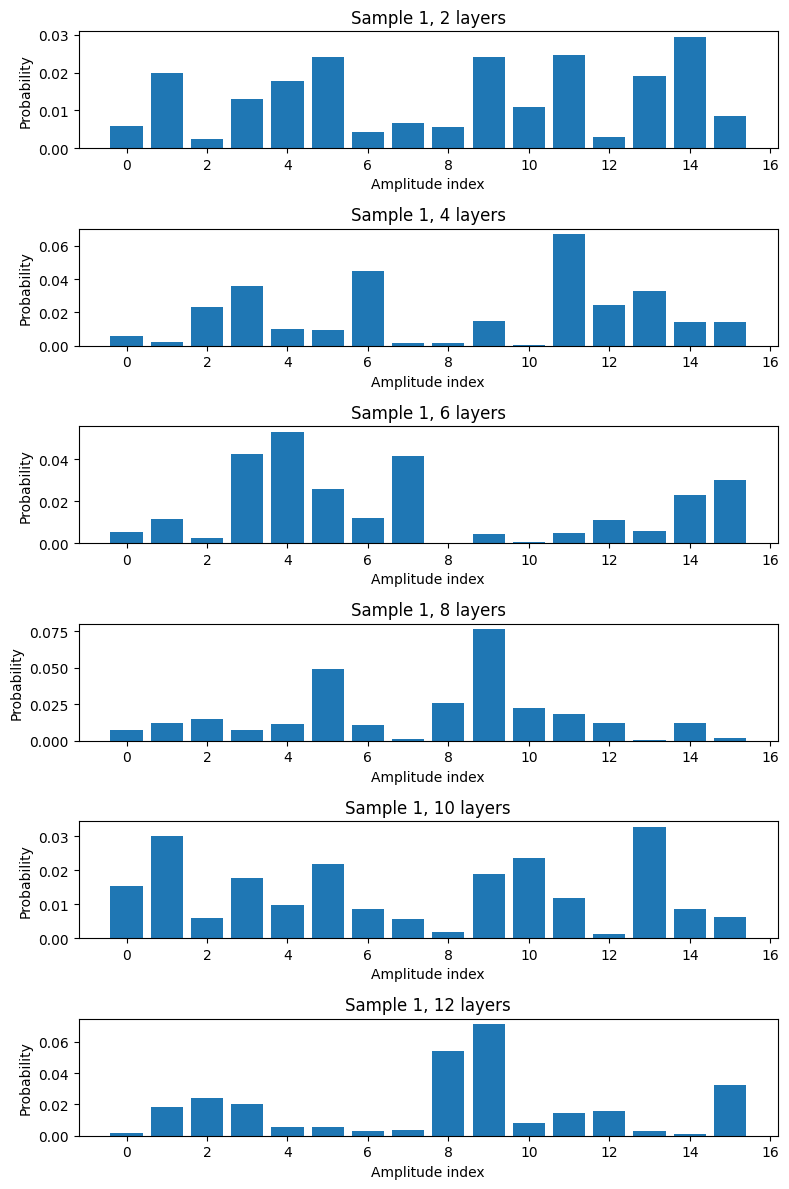

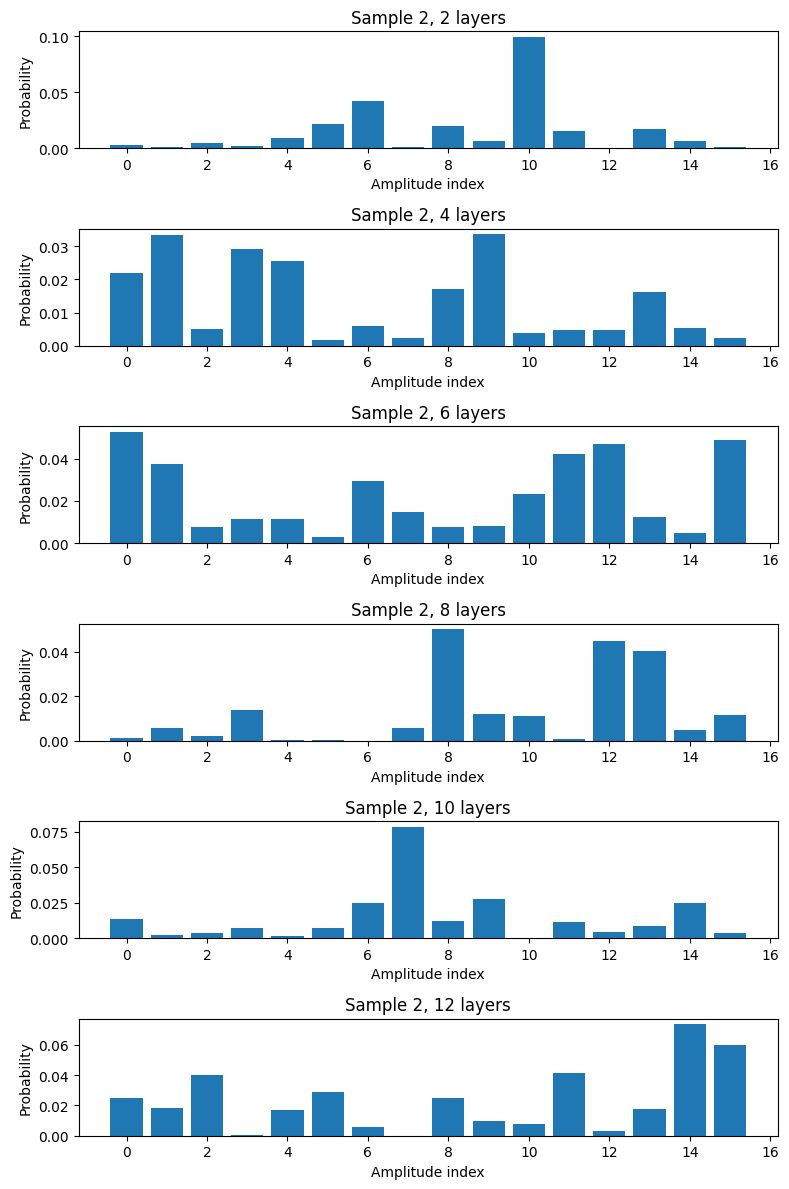

In [18]:
import matplotlib.pyplot as plt

# Pick a few sample images
sample_idx = [0, 1, 2]
layers_list = [2, 4, 6, 8, 10, 12]

for idx in sample_idx:
    fig, axes = plt.subplots(len(layers_list), 1, figsize=(8, 2*len(layers_list)))
    img_vec = X_train_qek[idx]

    for i, layers in enumerate(layers_list):
        # Generate theta for the current number of layers
        theta = np.random.uniform(0, 2*np.pi, size=(layers, n_qubits, 3))
        # Compute state
        state = qnode(img_vec, theta)

        # Plot first few amplitudes (e.g., first 16)
        axes[i].bar(range(16), np.abs(state[:16])**2)
        axes[i].set_title(f"Sample {idx}, {layers} layers")
        axes[i].set_ylabel("Probability")
        axes[i].set_xlabel("Amplitude index")

    plt.tight_layout()
    plt.show()

### Step 3: QJPEG Compression

In [19]:
def vectorization(img, Cr, Cc, renorm=False):
    "Vectorize the image into amplitude-encoding patches suitable for quantum circuits"
    # split the original image (Mr, Mc) into S equal-size patches of shape (Cr, Cc)
    Mr, Mc = img.shape
    assert Mr % Cr == 0 and Mc % Cc == 0
    patches = (img.reshape(Mc//Cr, Cr, -1, Cc).swapaxes(1, 2).reshape(-1, Cr, Cc))
    # 64 patches, (64, 64, 64) shape; S=64

    # vectorize each patch and collect all in a (N, Cr*Cc) array
    vect_patches = np.reshape(patches,  (patches.shape[0], Cr*Cc)) # (64, 4096)

    # normalize each (Cr*Cc) vector to the intensity of the corresponding (Cr, Cc) patch
    states = np.zeros((patches.shape[0], Cr*Cc)) # (64, 4096)
    norm = np.zeros(patches.shape[0])

    for idx in range(patches.shape[0]): # for each patch
        # compute the sum of pixels intensities
        norm[idx] = vect_patches[idx].sum()
        if norm[idx] == 0:
            # empty patch → encode |0...0>
            states[idx, 0] = 1.0
            norm[idx] = 1.0
            continue

        # normalize the patch vector so that its entries sum is 1
        tmp = vect_patches[idx] / norm[idx]
        # take the element-wise square root of the normalized vector
        states[idx] = np.sqrt(tmp)
    if renorm == False:
        norm = np.ones(patches.shape[0])
    print(states[:10])

    return states, norm # amplitudes, pixel intensities' sums

In [20]:
def qft_swaps(wires):
    n = len(wires)
    # apply QFT to all qubits
    qml.QFT(wires=wires)
    # add swaps to reverse qubit order!
    for i in range(n // 2):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])


def iqft_swaps(wires):
    n = len(wires)
    # swaps again - BEFORE iqft
    for i in reversed(range(n // 2)):
        qml.SWAP(wires=[wires[i], wires[n-i-1]])
    qml.adjoint(QFT)(wires=wires)

In [21]:
def circuit_builder(states, n0, n2, shots):
    ntilde = (n0 - n2) // 2
    n1 = n0 - ntilde

    qnodes = []

    # define device with n0 qubits
    dev = qml.device("lightning.qubit", wires=n0, shots=shots)

    for idx in range(states.shape[0]):
        # qnode to capture current input state
        @qml.qnode(dev)
        def circuit():
            # print("State norm:", np.linalg.norm(states[idx]))
            # initializing the state (using AmplitudeEmbedding here, but I'm wondering if something else could work faster)
            qml.AmplitudeEmbedding(states[idx], wires=range(n0))

            # Hadamard on all n0 qubits
            for w in range(n0):
                qml.Hadamard(wires=w)

            # apply QFT on all qubits
            qft_swaps(wires=range(n0))

            # apply IQFT on first n1 qubits
            iqft_swaps(wires=range(n1))

            # setting boundaries - Rule 2
            discard_start = n0 // 2 - ntilde
            discard_end = n0 // 2 - 1
            discarded_qubits = set(range(discard_start, discard_end + 1))

            # keep exactly n2 qubits for output
            measured_qubits = list(range(n2))


            # Hadamard on remaining qubits
            for q in measured_qubits:
                qml.Hadamard(wires=q)

            # print(f'Measured qubits: {measured_qubits}')

            return qml.probs(wires=measured_qubits)
        qnodes.append(circuit)

    return qnodes



In [22]:
def reconstruction(qnodes, n2, norm):
    out_freq = np.zeros((len(qnodes), 2**n2))
    for idx, qnode in enumerate(qnodes):
        probs = qnode()
        out_freq[idx] = qnode() * norm[idx]

    return out_freq

In [23]:
def devectorization(out_freq):
    S = out_freq.shape[0]
    nrow = int(np.sqrt(out_freq.shape[1])) # rows per patch
    ncol = nrow

    decoded_patches = np.reshape(out_freq,\
                      (out_freq.shape[0], nrow, ncol)) # (S, nrow, ncol)

    im_h, im_w = nrow*int(np.sqrt(S)), ncol*int(np.sqrt(S)) # final shape

    # initialization
    decoded_img = np.zeros((im_w, im_h))

    idx = 0
    for row in np.arange(im_h - nrow + 1, step=nrow):
        for col in np.arange(im_w - ncol + 1, step=ncol):
            decoded_img[row:row+nrow, col:col+ncol] = decoded_patches[idx]
            idx += 1

    return decoded_img

In [24]:
def qjpeg_feature_map(img_28x28, Cr=4, Cc=4, n2=2, shots=6000):
    """
    Apply patch-based QJPEG and return a fixed-size feature vector
    suitable for the quantum kernel.
    """

    assert img_28x28.shape == (28,28), f"Image has wrong shape {img_28x28.shape}"

    # 1. Vectorize image into patches
    states, norms = vectorization(img_28x28, Cr, Cc)

    # Each patch has size Cr*Cc → qubits
    n0 = int(np.log2(Cr * Cc))
    assert 2**n0 == Cr * Cc
    assert n2 <= n0

    # 2. Build QJPEG circuits (one per patch)
    qnodes = circuit_builder(states, n0=n0, n2=n2, shots=shots)

    # 3. Reconstruct low-frequency components
    out_freq = reconstruction(qnodes, n2, norms)

    # 4. Re-encode compressed image for kernel
    vec = out_freq.flatten()

    return vec / np.linalg.norm(vec)


### Step 4: Inference without retraining

In [25]:
# QJPEG features
X_train_qjpeg = np.array([
    qjpeg_feature_map(img.reshape(28,28))
    for img in X_train_img
])

X_test_qjpeg = np.array([
    qjpeg_feature_map(img.reshape(28,28))
    for img in X_test_img
])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


/usr/local/lib/python3.12/dist-packages/pennylane/devices/device_api.py:201: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [26]:
def qjpeg_to_qek_vector(img):
    # img is output of qjpeg_feature_map → 28x28 or similar
    img_8x8 = resize(
        img,
        (8, 8),
        anti_aliasing=False,
        preserve_range=True
    )
    vec = img_8x8.flatten().astype(float)
    norm = np.linalg.norm(vec)
    if norm == 0:
        vec[0] = 1.0
    else:
        vec /= norm
    return vec

In [27]:
X_train_qjpeg_qek = np.array([
    qjpeg_to_qek_vector(img) for img in X_train_qjpeg
])

X_test_qjpeg_qek = np.array([
    qjpeg_to_qek_vector(img) for img in X_test_qjpeg
])

In [28]:
states_test = np.array([qnode(x, theta) for x in X_test_qjpeg_qek])

In [29]:
print("Train state shape:", states_train[0].shape)
print("Test state shape:", states_test[0].shape)

Train state shape: (64,)
Test state shape: (64,)


In [31]:
def compute_kernel_cross(support_states, test_states):
    K = np.zeros((len(test_states), len(support_states)))
    for i in range(len(test_states)):
        for j in range(len(support_states)):
            ip = np.vdot(test_states[i], support_states[j])
            K[i, j] = np.real(ip * np.conj(ip))
    return K

support_states = states_train[svc.support_]

# compute kernel between all training states and test states
K_test_qjpeg = compute_kernel_cross(states_train, states_test)

# normalize using same factor as training kernel
K_test_qjpeg /= K_train.max()

# now predict
print("K_test_qjpeg shape:", K_test_qjpeg.shape)
print("Expected:", (len(y_test), len(svc.support_)))

y_pred_qjpeg = svc.predict(K_test_qjpeg)
print("Accuracy (QJPEG):", accuracy_score(y_test, y_pred_qjpeg))

K_test_qjpeg shape: (20, 80)
Expected: (20, 74)
Accuracy (QJPEG): 0.55


In [33]:
print(K_train_norm.shape)   # (4800, 4800)
print(K_test_qjpeg.shape)   # (n_test, 4800)

(80, 80)
(20, 80)


In [34]:
y_pred_qjpeg = svc.predict(K_test_qjpeg)

print("Accuracy (QJPEG):", accuracy_score(y_test, y_pred_qjpeg))

Accuracy (QJPEG): 0.55
